# import packages

In [363]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import s, l, f, te
from pygam import LinearGAM as linear_gam

# set seaborn look

In [364]:
sns.set(context = "notebook", style = "darkgrid", palette = "colorblind")

# read tabular data from html

In [365]:
biden_favorability_recent, biden_favorability_full = pd.read_html("https://www.realclearpolitics.com/epolls/other/joe_biden_favorableunfavorable-6677.html")

# rename columns

In [366]:
biden_favorability_full.columns = ["poll", "poll_period", "sample_size_population", "favorable_pct", "unfavorable_pct", "net_favorable_pct"]

# remove rcp average row

In [367]:
biden_favorability_full = biden_favorability_full.loc[biden_favorability_full["poll"] != "RCP\xa0Average", ].reset_index()

# remove "Tie" from net favorability variable

In [368]:
biden_favorability_full["net_favorable_pct"] = biden_favorability_full["net_favorable_pct"].astype(str).str.replace("Tie", "0")

# parse dates

In [369]:
biden_favorability_full[["start_date", "end_date"]] = biden_favorability_full["poll_period"].str.split(" - ").apply(pd.Series)

# parse months and days from date strings

In [370]:
# start month and day
biden_favorability_full[["start_month", "start_day"]] = biden_favorability_full["start_date"].str.split("/").apply(pd.Series)

# end month and day
biden_favorability_full[["end_month", "end_day"]] = biden_favorability_full["end_date"].str.split("/").apply(pd.Series)

# parse sample size and polling population

In [371]:
biden_favorability_full[["sample_size", "polling_population"]] = biden_favorability_full["sample_size_population"].str.split(" ").apply(pd.Series)

# replace "," in sample size
biden_favorability_full["sample_size"] = biden_favorability_full["sample_size"].astype(str).str.replace(",", "")

# cumulative sum of december polling start and end dates

In [372]:
biden_favorability_full["start_december_cumsum"] = (biden_favorability_full["start_month"] == "12").cumsum()
biden_favorability_full["end_december_cumsum"] = (biden_favorability_full["end_month"] == "12").cumsum()

# use cumulative sum to determine year
This is the dumbest solution in the notebook

In [373]:
# recode cumulative sum integer to year string
def cumsum2year(x):
    if x == 0:
        return "2020"
    elif x > 7 and x < 10:
        return "2019"
    else:
        return "2018"

# start adn end year
biden_favorability_full["start_year"] = biden_favorability_full["start_december_cumsum"].apply(cumsum2year)
biden_favorability_full["end_year"] = biden_favorability_full["start_december_cumsum"].apply(cumsum2year)

# create start and end dates and their midpoint

In [374]:
biden_favorability_full["start_date"] = pd.to_datetime(biden_favorability_full[["start_year", "start_month", "start_day"]].apply(lambda row: "/".join(row.values.astype(str)), axis = 1))
biden_favorability_full["end_date"] = pd.to_datetime(biden_favorability_full[["end_year", "end_month", "end_day"]].apply(lambda row: "/".join(row.values.astype(str)), axis = 1))
biden_favorability_full["median_date"] = biden_favorability_full["start_date"] + (biden_favorability_full["end_date"] - biden_favorability_full["start_date"]) / 2

# change data types

In [375]:
biden_favorability_full[["net_favorable_pct", "sample_size", "start_year", "start_month", "start_day", "end_year", "end_month", "end_day"]] = biden_favorability_full[["net_favorable_pct", "sample_size", "start_year", "start_month", "start_day", "end_year", "end_month", "end_day"]].astype(int)

# fit linear GAM

In [376]:
# linear GAM fit
gam_fit = linear_gam(s(0)).fit(biden_favorability_full["median_date"], biden_favorability_full["net_favorable_pct"], weights = biden_favorability_full["sample_size"])

# add predictions to data frame
biden_favorability_full["net_favorable_pct_hat"] = gam_fit.predict(biden_favorability_full["median_date"])

# plot GAM predictions compared to 7-day rolling average

Text(0, 0.5, '')

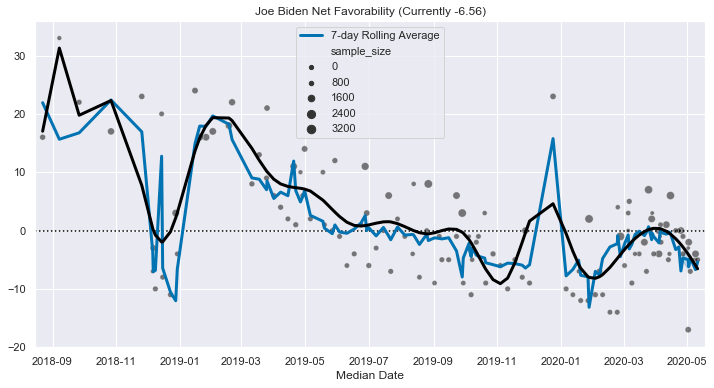

In [377]:
# save 7-day rolling average sample size weights
weights_7dra = biden_favorability_full["sample_size"] / biden_favorability_full["sample_size"].rolling(window = 7, min_periods = 2).mean()

# save figure and axes objects
figure, axes = plt.subplots(figsize = (12, 6))

# scatterplot and lineplot using lowess fit above
axes.axhline(y = 0, linestyle = "dotted", c = "black")
sns.lineplot(x = biden_favorability_full["median_date"], y = biden_favorability_full["net_favorable_pct"].rolling(window = 7, min_periods = 2).mean() * weights_7dra, label = "7-day Rolling Average", linewidth = 3)
sns.lineplot(y = "net_favorable_pct_hat", x = "median_date", data = biden_favorability_full, linewidth = 3, color = "black")
sns.scatterplot(x = "median_date", y = "net_favorable_pct", data = biden_favorability_full, color = "black", size = "sample_size", alpha = 0.50)

# set x-axis limits
axes.set_xlim(biden_favorability_full["median_date"].min() - np.timedelta64(1, "W"), biden_favorability_full["median_date"].max() + np.timedelta64(1, "W"))

# set titles
axes.set_title("Joe Biden Net Favorability (Currently {})".format(biden_favorability_full["net_favorable_pct_hat"][biden_favorability_full.end_date == biden_favorability_full.end_date.max()].round(2).squeeze()))
axes.set_xlabel(xlabel = "Median Date")
axes.set_ylabel(ylabel = None)